In [123]:
import json
import numpy as np
import gurobipy
import preference_models_utils
from gurobipy import Model, GRB, quicksum
import pandas as pd
import networkx as nx
import plotly.express as px
import utils

from preference_models_utils import create_planning, create_tables, dominate, ModelDataSommePonderee, get_preorder, create_graph, run_model_uta, PrometheeI

In [124]:
toy_solutions = utils.load_output("solutions/toy_instance_solution.json.gz")

#medium_solutions = utils.load_output("medium_instance_solution.json.gz")

#large_solutions = utils.load_output("solutions/large_instance_solution.json.gz")

In [125]:
solutions = utils.filter_solutions(toy_solutions)

#solutions = utils.filter_solutions(medium_solutions)

#solutions = utils.filter_solutions(large_solutions)

In [126]:
dim = 3
filtered_solutions = np.empty((len(solutions), dim))
for idx, solution in enumerate(solutions):
    filtered_solutions[idx, :] = [solution.f1, solution.f2, solution.f3]

In [127]:
df_solutions = pd.DataFrame(-1*np.array(filtered_solutions))
df_solutions.rename(columns={0: 'f1', 1: 'f2', 2:'f3'}, inplace=True)

### UTA

In [128]:
ranking_small = [9, 3, 1]
ranking_medium = [32, 41, 36,  6, 27,  3, 23, 22, 40, 37] 
ranking_large = [27,  8, 11,  7, 40, 12, 17, 53, 33, 34] 

ranking = ranking_small

choices = df_solutions[['f1', 'f2', 'f3']].copy().to_numpy()

In [129]:
model_uta, data_uta = run_model_uta(choices, ranking)
df_solutions_uta = df_solutions.copy()
df_solutions_uta['scores'] = data_uta.scores

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [130]:
df_solutions_uta.sort_values(by='scores', ascending=False)

,f1,f2,f3,scores
7,65.0,-3.0,-2.0,1.911667
9,65.0,-2.0,-3.0,1.910000
4,59.0,-4.0,-1.0,1.737949
6,55.0,-2.0,-2.0,1.624359
3,49.0,-3.0,-1.0,1.450641
8,42.0,-1.0,-3.0,1.242692
2,37.0,-2.0,-1.0,1.104872
5,30.0,-1.0,-2.0,0.898590
1,20.0,-1.0,-1.0,0.612949
0,-0.0,-0.0,-0.0,0.040000


/tmp/ipykernel_130867/2447821270.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


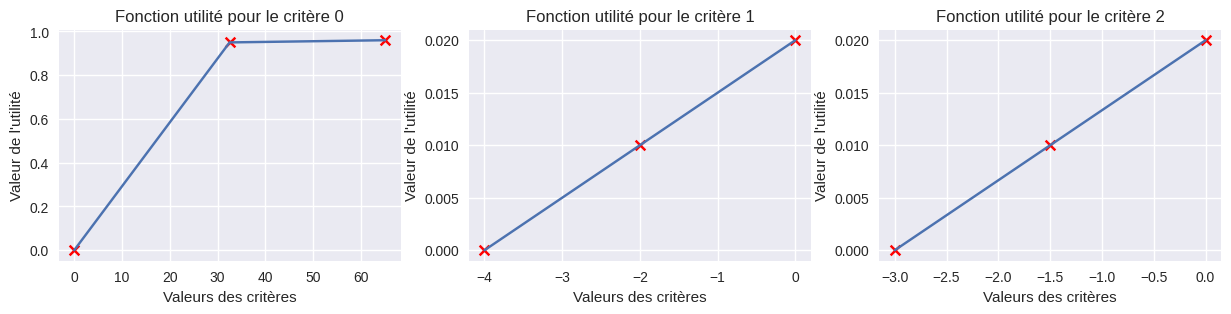

In [131]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
for d in range(3):
    x = data_uta.dim_vals[d]
    y = [x.X for x in data_uta.s_i_x_k[d].values()] 
    ax[d].set_title(f'Fonction utilité pour le critère {d}')
    ax[d].set_xlabel(f'Valeurs des critères')
    ax[d].set_ylabel(f'Valeur de l\'utilité')
    ax[d].plot(x, y)
    ax[d].scatter(x, y, c='r', marker='x')

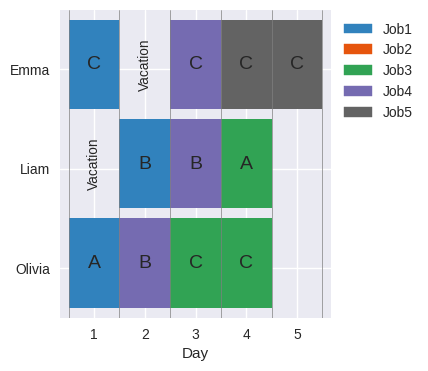

In [141]:
best_solution_idx = df_solutions_uta.sort_values(by='scores', ascending=False).index[0]
utils.plot_solution(solutions[best_solution_idx])

### Weighted sum

In [142]:
preference_list_small = [
    (9,   3),
    (9,   1),
    (3,   1),
]
preference_list_medium = [
    (9,     3),
    (9,     1),
    (3,     1),
    (12,    7),
    (30,    6),
    (31,   35),
    (40,   30)
]

preference_list_large = [
    (27,  3),
    (27,  4),
    (27,  55),
    (57,  56),
    (58,  52),
    (58,  3),
    (57,  8),
    (58,  2),
    (23,  8),
    (4,   5),
    (21,  27),
    (35,  27),
    (35,  38),
    (21,  34)
]

preference_list = preference_list_small

,f1,f2,f3,degree
7,65.0,-3.0,-2.0,8
9,65.0,-2.0,-3.0,8
4,59.0,-4.0,-1.0,4
6,55.0,-2.0,-2.0,4
3,49.0,-3.0,-1.0,1
8,42.0,-1.0,-3.0,-1
2,37.0,-2.0,-1.0,-3
5,30.0,-1.0,-2.0,-5
1,20.0,-1.0,-1.0,-7
0,-0.0,-0.0,-0.0,-9


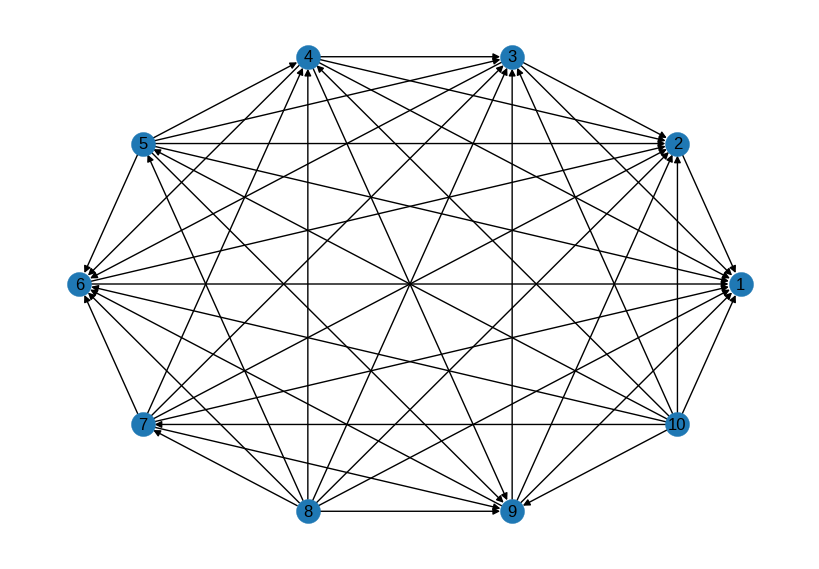

In [143]:
choices = df_solutions[['f1', 'f2', 'f3']].copy().to_numpy()
preordre_model, preordre_data = get_preorder(choices, preference_list)

G = create_graph(preordre_data, True)

df_solutions_wsum = df_solutions.copy()
df_solutions_wsum['degree'] = [G.out_degree(node) - G.in_degree(node) for node in G.nodes]  
df_solutions_wsum.sort_values(by='degree', ascending=False)

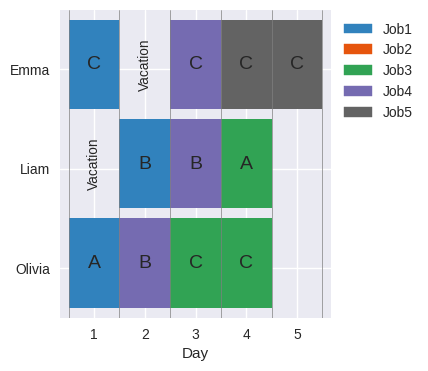

In [144]:
best_solution_idx = df_solutions_wsum.sort_values(by='degree', ascending=False).index[0]
utils.plot_solution(solutions[best_solution_idx])

#### Outranking: PROMETHEE I

In [145]:
W = [x.X for x in preordre_data.Poids.values()]
S = [20, 1, 2]
config_params = {
    "dim": 3,
    "W": W,
    "S": S,
    "choices": choices
}

promethee = PrometheeI(**config_params)

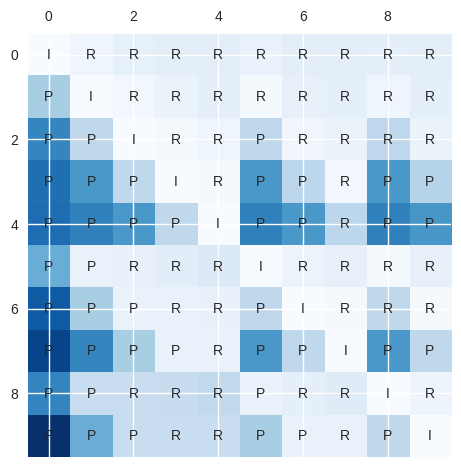

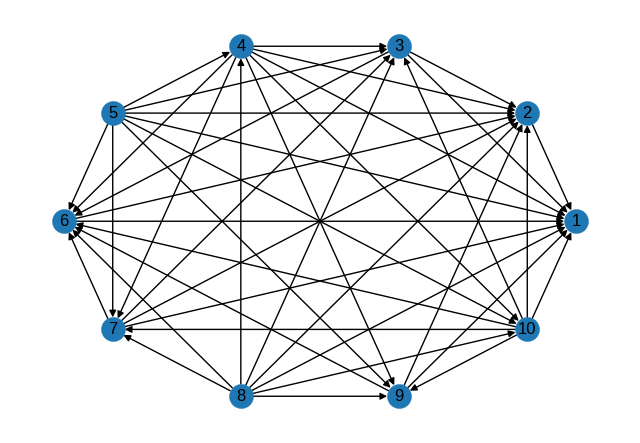

In [146]:
promethee.get_preorder()
promethee.plot_preferences()
promethee.plot_graph()